22K-5365  CV ASSIGNMENT 03

### IMPORT

In [1]:
!nvidia-smi

Fri May 24 17:01:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
from PIL import Image

In [4]:
import seaborn as sns

In [5]:
import pathlib

In [6]:
from google.colab import drive

### LOAD DATASETS

In [7]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
# Set the data directory path
data_dir = '/content/gdrive/MyDrive/rice_leaf_diseases'

In [9]:
# Convert data_dir to a pathlib Path object
data_dir = pathlib.Path(data_dir)

In [10]:
# Get the list of image files with their corresponding labels
image_data = list(data_dir.glob('*/*.[jJ][pP][gG]'))

In [11]:
# Determine the total number of images
image_count = len(image_data)
print(f"Total number of images in the Leaf Disease Dataset: {image_count}")

Total number of images in the Leaf Disease Dataset: 120


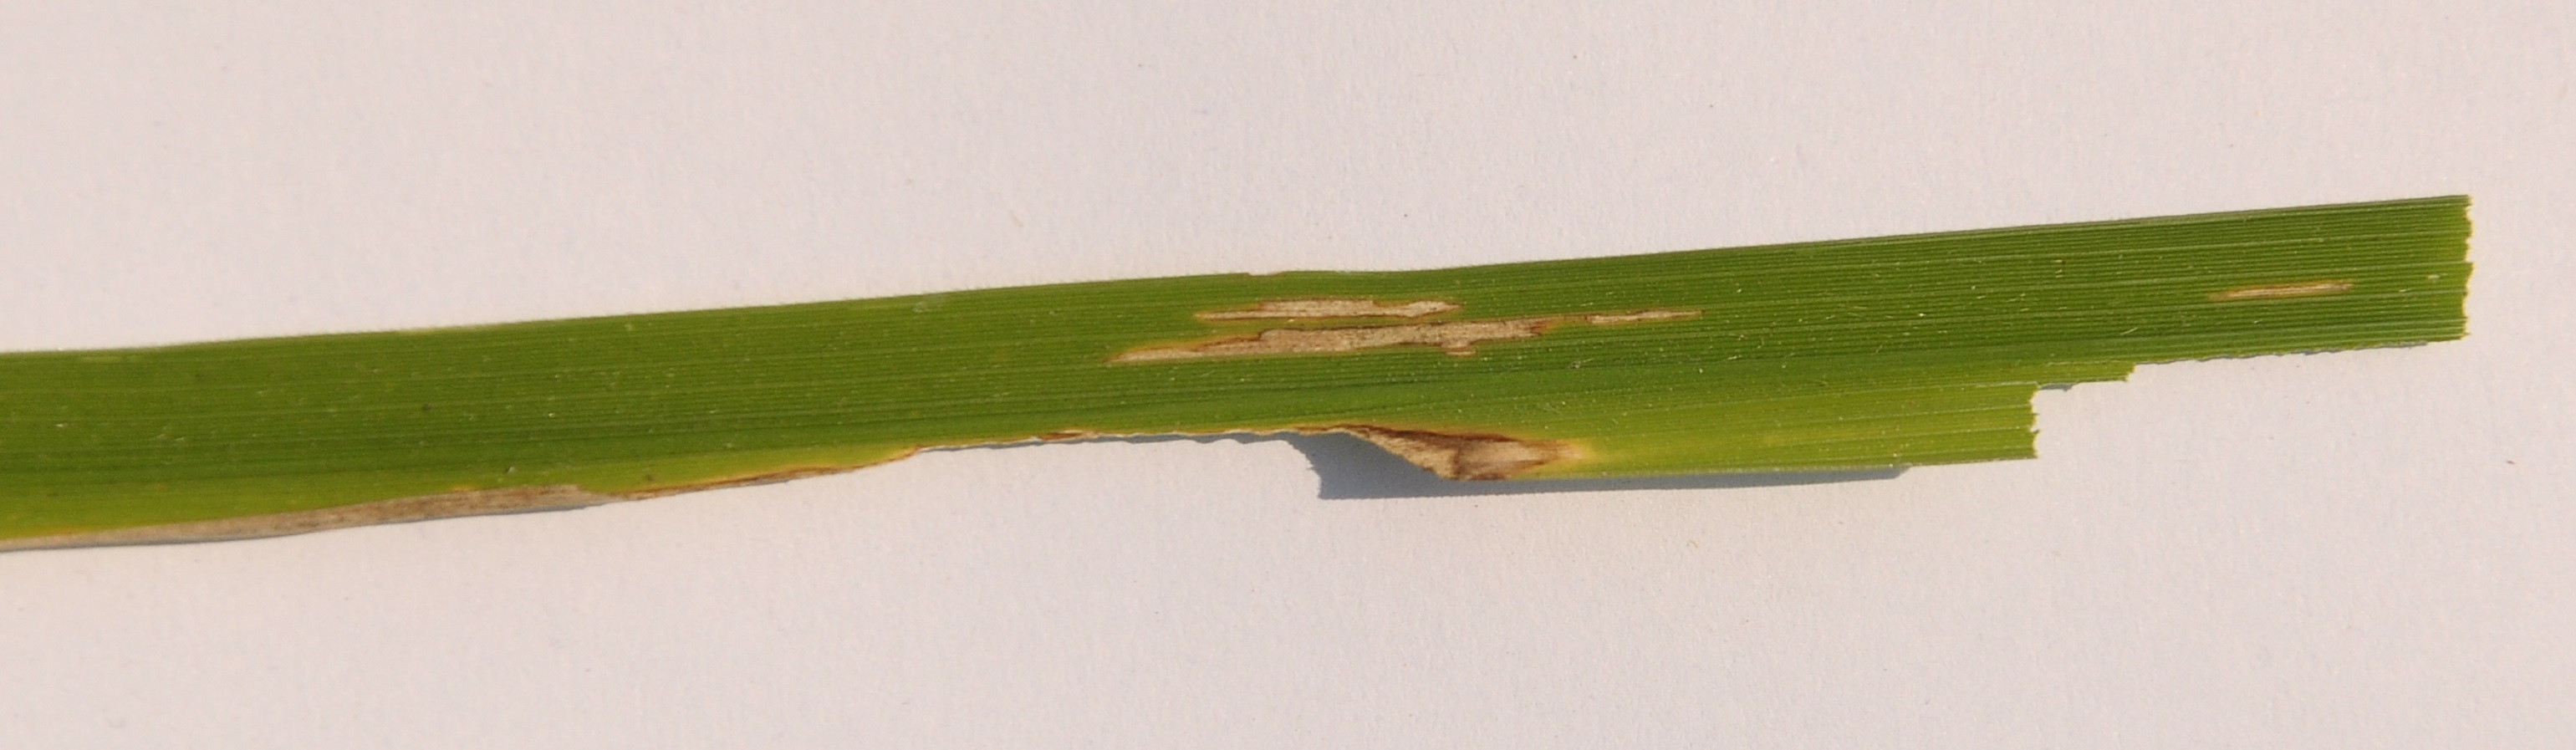

In [12]:
# Defining bacterial leaf blight images
Bacterial_leaf_blight = list(data_dir.glob('Bacterial leaf blight/*'))
Image.open(str(Bacterial_leaf_blight[0]))

In [13]:
Bacterial_leaf_blight_count=len(Bacterial_leaf_blight)
Bacterial_leaf_blight_count

40

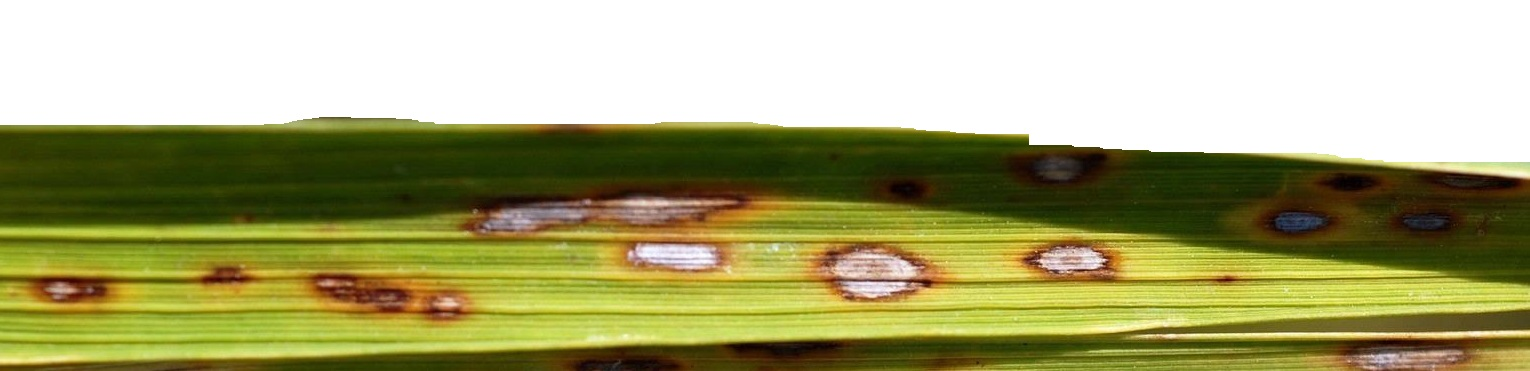

In [14]:
# Defining brown spot disease images
Brown_spot = list(data_dir.glob('Brown spot/*'))
Image.open(str(Brown_spot[0]))

In [15]:
Brown_spot_count=len(Brown_spot)
Brown_spot_count

40

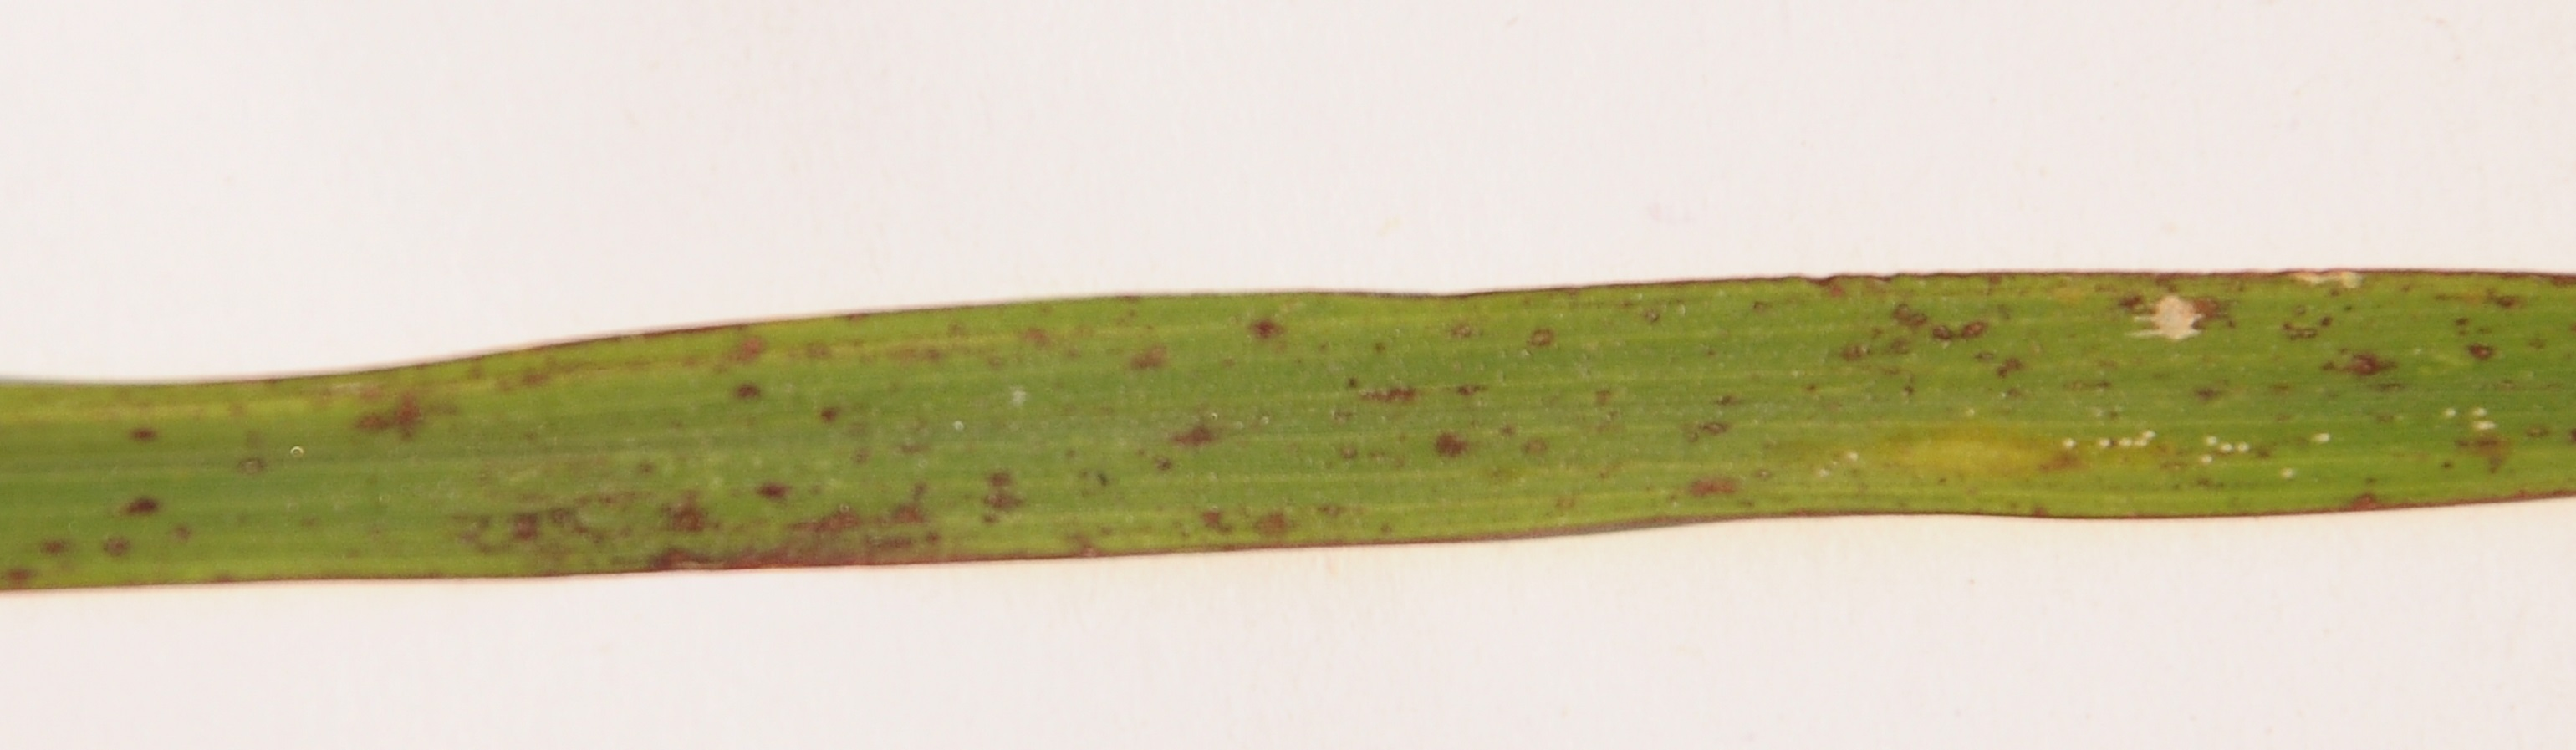

In [16]:
# Defining leaf smut images
Leaf_smut = list(data_dir.glob('Leaf smut/*'))
Image.open(str(Leaf_smut[0]))

In [18]:
Leaf_smut_count=len(Leaf_smut)
Leaf_smut_count

40

### PRE-PROCESSING

In [19]:
#Create lists to store the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in data_dir.iterdir():
    if subfolder.is_dir():
        # Loop over the images in the subfolder
        for image_file in subfolder.iterdir():
            if image_file.suffix.lower() == '.jpg':
                # Load the image and store it in the images list
                images.append(str(image_file))
                # Store the label for the image in the labels list
                labels.append(subfolder.name)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [20]:
len(images)

120

In [21]:
#Number of labels
df["label"].nunique()

3

In [22]:
#Label names
df["label"].unique()

array(['Bacterial leaf blight', 'Brown spot', 'Leaf smut'], dtype=object)

In [23]:
mask_label = "Bacterial leaf blight"
df_ar = df[df["label"] == mask_label]
df_ar.head()

image                  label
0  /content/gdrive/MyDrive/rice_leaf_diseases/Bac...  Bacterial leaf blight
1  /content/gdrive/MyDrive/rice_leaf_diseases/Bac...  Bacterial leaf blight
2  /content/gdrive/MyDrive/rice_leaf_diseases/Bac...  Bacterial leaf blight
3  /content/gdrive/MyDrive/rice_leaf_diseases/Bac...  Bacterial leaf blight
4  /content/gdrive/MyDrive/rice_leaf_diseases/Bac...  Bacterial leaf blight

Text(0, 0.5, 'Number of Samples per Class')

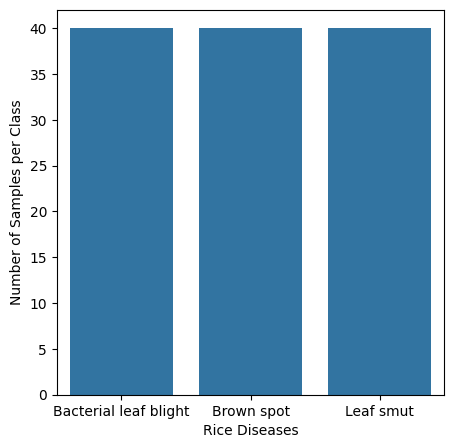

In [24]:
plt.figure(figsize=(5,5))

ax=sns.countplot(x=df.label)
ax.set_xlabel("Rice Diseases")
ax.set_ylabel("Number of Samples per Class")

### SPLITTING THE DATASET INTO TEST TRAIN SPLIT

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df["image"], df["label"], test_size=0.2, random_state=786)

In [26]:
df_train = pd.DataFrame({'image': x_train, 'label': y_train})

In [27]:
df_test = pd.DataFrame({'image': x_test, 'label': y_test})

In [28]:
encoder=LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [29]:
y_train

array([1, 2, 0, 1, 0, 2, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1,
       0, 0, 2, 1, 2, 2, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1,
       1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2,
       1, 1, 2, 1, 0, 0, 1, 0, 2, 2, 0, 1, 2, 1, 0, 1, 1, 0, 2, 0, 1, 0,
       2, 2, 0, 2, 2, 1, 2, 0])

### DATA AUGMENTATION

In [30]:
from keras.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


### APPLYING CNN

In [31]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D , Flatten, Dense

In [32]:
input_shape=(50,50,3)

In [33]:
from keras.layers import Dropout
from keras.regularizers import l2

In [34]:
model=Sequential()
model.add(Conv2D(32, kernel_size=(3,3),activation="relu", input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))  # Dropout 25% of the nodes
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [35]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [36]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
3/3 [==============================] - 31s 8s/step - loss: 1.6781 - accuracy: 0.3646 - val_loss: 1.2890 - val_accuracy: 0.2500
Epoch 2/20
3/3 [==============================] - 2s 677ms/step - loss: 1.1657 - accuracy: 0.3229 - val_loss: 1.0916 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 2s 638ms/step - loss: 1.1193 - accuracy: 0.3229 - val_loss: 1.0876 - val_accuracy: 0.3750
Epoch 4/20
3/3 [==============================] - 2s 678ms/step - loss: 1.0804 - accuracy: 0.4271 - val_loss: 1.1214 - val_accuracy: 0.2083
Epoch 5/20
3/3 [==============================] - 2s 572ms/step - loss: 1.0609 - accuracy: 0.3750 - val_loss: 1.1388 - val_accuracy: 0.2500
Epoch 6/20
3/3 [==============================] - 2s 625ms/step - loss: 1.0364 - accuracy: 0.3854 - val_loss: 1.1200 - val_accuracy: 0.3333
Epoch 7/20
3/3 [==============================] - 2s 979ms/step - loss: 1.0280 - accuracy: 0.4583 - val_loss: 1.1856 - val_accuracy: 0.3750
Epoch 8/20
3/3 [======

### EVALUATING THE MODEL

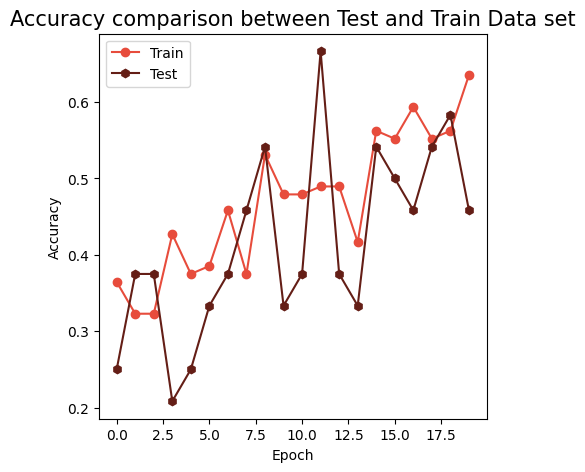

In [37]:
# Plot accuracy comparison between Validation and Train Data set
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Test and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [39]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

1/1 [==============================] - 0s 362ms/step - loss: 1.2262 - accuracy: 0.4583
Accuracy: 0.4583333432674408


Accuracy: 0.4583333333333333
Recall: 0.4583333333333333
Precision: 0.28125


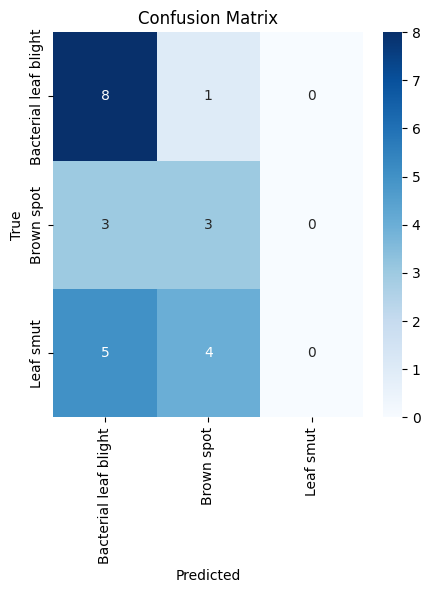

In [40]:
# Step 1: Make predictions using the trained model on the test data
y_pred = model.predict_generator(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the test data generator
y_true = test_generator.classes

# Step 2: Calculate accuracy, recall, and precision
accuracy_CNN = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy_CNN)
print("Recall:", recall)
print("Precision:", precision)

# Step 3: Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### APPLYING ALEXNET

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
from keras.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (227, 227)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


In [43]:
input_shape=(227,227,3)

In [48]:
#Number of labels
num_classes=df["label"].nunique()

In [49]:
# Define the AlexNet model
def build_alexnet(input_shape, num_classes):
    model = Sequential()

    # 1st Convolutional Layer
    model.add(Conv2D(96, (11, 11), input_shape=input_shape, strides=(4, 4), padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

    # 2nd Convolutional Layer
    model.add(Conv2D(256, (5, 5), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

    # 3rd Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))

    # 4th Convolutional Layer
    model.add(Conv2D(384, (3, 3), strides=(1, 1), padding='same', activation='relu'))

    # 5th Convolutional Layer
    model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid'))

    # Flatten the output
    model.add(Flatten())

    # 1st Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # 2nd Fully Connected Layer
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(3, activation='softmax'))

    return model

In [50]:
# Build the AlexNet model
model = build_alexnet(input_shape, num_classes)

In [51]:
# Compile the model
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['accuracy'])

In [52]:
# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 384)       885120    
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 384)      

In [54]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
3/3 [==============================] - 4s 2s/step - loss: 3.8829 - accuracy: 0.2812 - val_loss: 1.0994 - val_accuracy: 0.3750
Epoch 2/20
3/3 [==============================] - 4s 1s/step - loss: 1.1007 - accuracy: 0.2396 - val_loss: 1.1094 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 1.1186 - accuracy: 0.3021 - val_loss: 1.1011 - val_accuracy: 0.3750
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 1.0999 - accuracy: 0.3125 - val_loss: 1.1019 - val_accuracy: 0.2500
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 1.0987 - accuracy: 0.3542 - val_loss: 1.1024 - val_accuracy: 0.2500
Epoch 6/20
3/3 [==============================] - 4s 1s/step - loss: 1.0977 - accuracy: 0.3542 - val_loss: 1.1033 - val_accuracy: 0.2500
Epoch 7/20
3/3 [==============================] - 3s 969ms/step - loss: 1.1048 - accuracy: 0.3125 - val_loss: 1.1024 - val_accuracy: 0.2500
Epoch 8/20
3/3 [======================

### EVALUATING THE MODEL

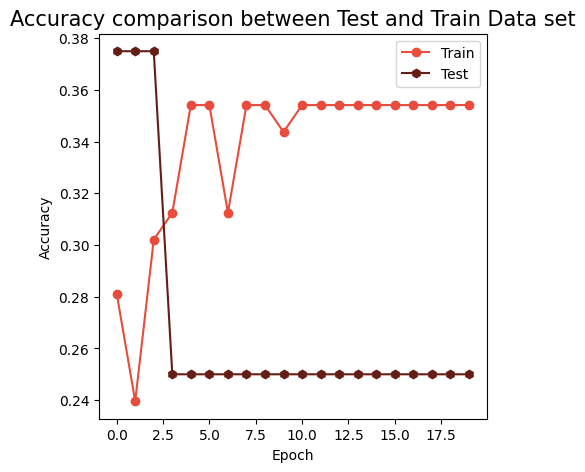

In [55]:
# Plot accuracy comparison between Validation and Train Data set
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Test and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [56]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

1/1 [==============================] - 0s 420ms/step - loss: 1.1075 - accuracy: 0.2500
Accuracy: 0.25


Accuracy: 0.25
Recall: 0.25
Precision: 0.0625


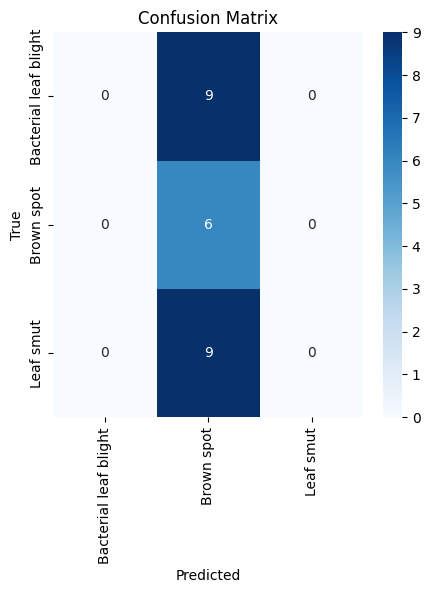

In [57]:
# Step 1: Make predictions using the trained model on the test data
y_pred = model.predict_generator(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the test data generator
y_true = test_generator.classes

# Step 2: Calculate accuracy, recall, and precision
accuracy_alexnet = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy_alexnet)
print("Recall:", recall)
print("Precision:", precision)

# Step 3: Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### APPLYING RESNET

In [58]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming df_train and df_test are your training and testing dataframes
num_classes = df_train["label"].nunique()

In [59]:
num_classes

3

In [60]:
# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


In [61]:
# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 [==============================] - 0s 0us/step


In [62]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [63]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
3/3 [==============================] - 48s 2s/step - loss: 1.3858 - accuracy: 0.5417 - val_loss: 7.1305 - val_accuracy: 0.2500
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.9396 - accuracy: 0.7917 - val_loss: 12.6926 - val_accuracy: 0.3750
Epoch 3/20
3/3 [==============================] - 4s 1s/step - loss: 0.4660 - accuracy: 0.8542 - val_loss: 2064.8635 - val_accuracy: 0.2500
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 0.4763 - accuracy: 0.8125 - val_loss: 25301.2734 - val_accuracy: 0.2500
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.3633 - accuracy: 0.8750 - val_loss: 51508.5117 - val_accuracy: 0.2500
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.3444 - accuracy: 0.8646 - val_loss: 35834.4961 - val_accuracy: 0.2500
Epoch 7/20
3/3 [==============================] - 4s 2s/step - loss: 0.5544 - accuracy: 0.9062 - val_loss: 76496.0391 - val_accuracy: 0.3750
Epoch 8/20
3/3 [====

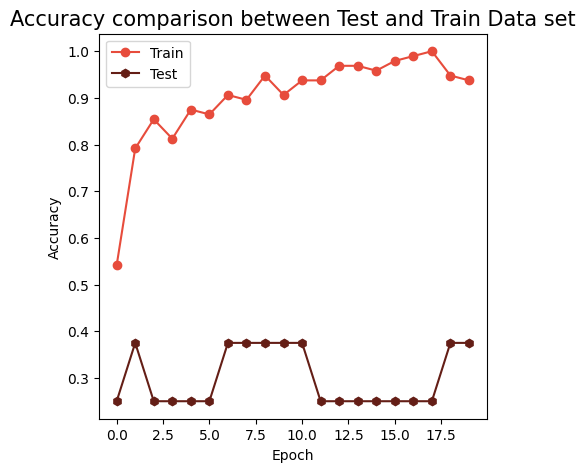

In [64]:
# Plot accuracy comparison between Validation and Train Data set
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Test and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [65]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

1/1 [==============================] - 1s 1s/step - loss: 203.0861 - accuracy: 0.3750
Accuracy: 0.375


Accuracy: 0.375
Recall: 0.375
Precision: 0.140625


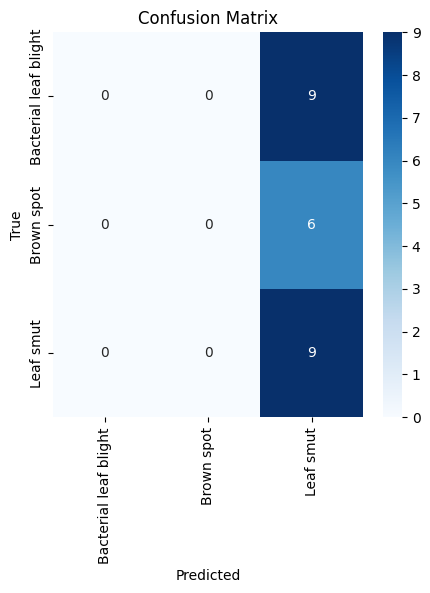

In [66]:
# Step 1: Make predictions using the trained model on the test data
y_pred = model.predict_generator(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the test data generator
y_true = test_generator.classes

# Step 2: Calculate accuracy, recall, and precision
accuracy_resnet = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy_resnet)
print("Recall:", recall)
print("Precision:", precision)

# Step 3: Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### APPLYING GOOGLENET

In [99]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [100]:
num_classes = df_train["label"].nunique()

In [101]:
num_classes

3

In [102]:
input_shape = (224, 224, 3)

In [103]:

# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],  # Target size should be width and height only
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=input_shape[:2],  # Target size should be width and height only
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


In [104]:
def inception_module(x, filters):
    # 1x1 Convolution
    conv1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same', activation='relu')(x)

    # 3x3 Convolution
    conv3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same', activation='relu')(x)

    # 5x5 Convolution
    conv5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), padding='same', activation='relu')(x)

    # Max pooling
    maxpool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    maxpool_conv = Conv2D(filters=filters[3], kernel_size=(1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate the outputs
    output = concatenate([conv1x1, conv3x3, conv5x5, maxpool_conv], axis=-1)
    return output

In [105]:
def build_googlenet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)

    # Stage 1
    conv1 = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
    maxpool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)

    # Stage 2
    conv2a = Conv2D(filters=64, kernel_size=(1, 1), padding='same', activation='relu')(maxpool1)
    conv2b = Conv2D(filters=192, kernel_size=(3, 3), padding='same', activation='relu')(conv2a)
    maxpool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv2b)

    # Stage 3 - Inception modules
    inception3a = inception_module(maxpool2, [64, 96, 128, 16])
    inception3b = inception_module(inception3a, [128, 128, 192, 32])
    maxpool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception3b)

    # Stage 4 - Inception modules
    inception4a = inception_module(maxpool3, [192, 96, 208, 16])
    inception4b = inception_module(inception4a, [160, 112, 224, 24])
    inception4c = inception_module(inception4b, [128, 128, 256, 24])
    inception4d = inception_module(inception4c, [112, 144, 288, 32])
    inception4e = inception_module(inception4d, [256, 160, 320, 32])
    maxpool4 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(inception4e)

    # Stage 5 - Inception modules
    inception5a = inception_module(maxpool4, [256, 160, 320, 32])
    inception5b = inception_module(inception5a, [384, 192, 384, 48])

    # Average pooling
    avgpool = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(inception5b)

    # Flatten the output
    flatten = Flatten()(avgpool)

    # Fully connected layer
    dense = Dense(units=num_classes, activation='softmax')(flatten)

    # Create model
    model = tf.keras.Model(inputs=input_layer, outputs=dense)

    return model

In [106]:
model = build_googlenet(input_shape, num_classes)

In [107]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [108]:
# Train the model on the training data
history = model.fit_generator(train_generator,epochs=20,validation_data=test_generator)

Epoch 1/20
3/3 [==============================] - 16s 894ms/step - loss: 59.9020 - accuracy: 0.3542 - val_loss: 1.2196 - val_accuracy: 0.3333
Epoch 2/20
3/3 [==============================] - 3s 993ms/step - loss: 1.1483 - accuracy: 0.3333 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 1.1191 - accuracy: 0.2812 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 4/20
3/3 [==============================] - 4s 1s/step - loss: 1.0990 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 1.0993 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/20
3/3 [==============================] - 3s 998ms/step - loss: 1.0988 - accuracy: 0.3333 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 7/20
3/3 [==============================] - 4s 1s/step - loss: 1.1000 - accuracy: 0.3333 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 8/20
3/3 [==============

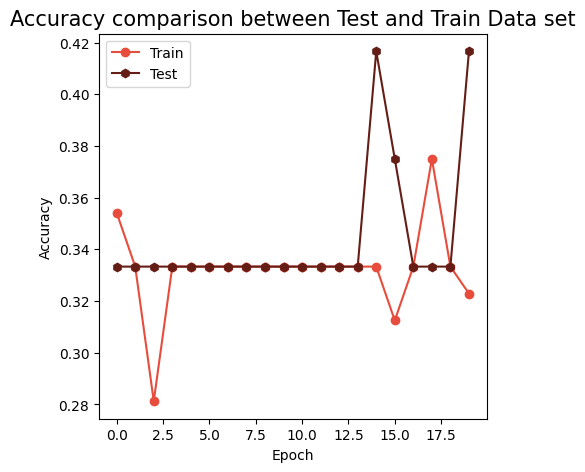

In [111]:
# Plot accuracy comparison between Validation and Train Data set
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'], color="#E74C3C", marker='o')
plt.plot(history.history['val_accuracy'], color='#641E16', marker='h')
plt.title('Accuracy comparison between Test and Train Data set', fontsize=15)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

In [112]:
# Evaluate the model on the test data
metrics = model.evaluate(test_generator)
# Print the accuracy of the model
print('Accuracy:', metrics[1])

1/1 [==============================] - 1s 542ms/step - loss: 1.0981 - accuracy: 0.4167
Accuracy: 0.4166666567325592


Accuracy: 0.4166666666666667
Recall: 0.4166666666666667
Precision: 0.2801120448179271


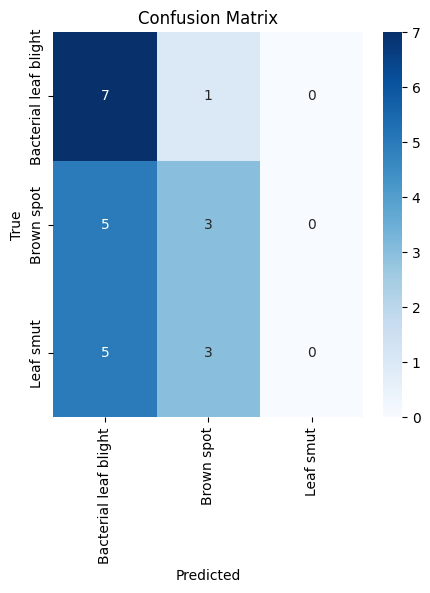

In [113]:
# Step 1: Make predictions using the trained model on the test data
y_pred = model.predict_generator(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the test data generator
y_true = test_generator.classes

# Step 2: Calculate accuracy, recall, and precision
accuracy_googlenet = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy_googlenet)
print("Recall:", recall)
print("Precision:", precision)

# Step 3: Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

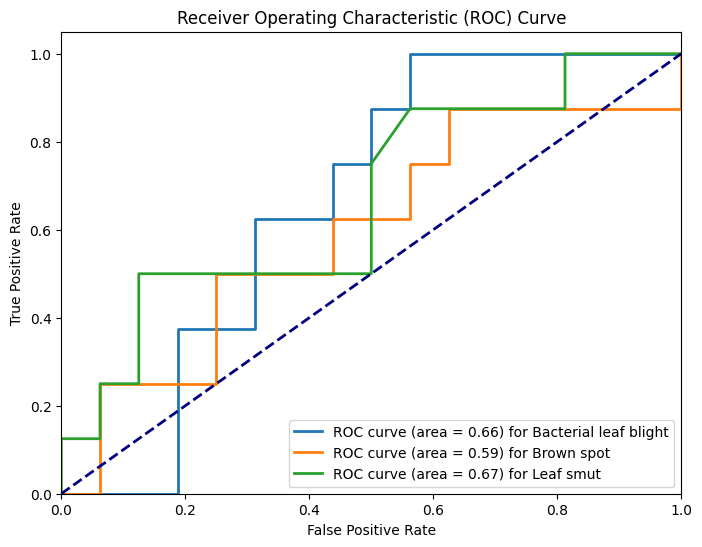

In [114]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Step 1: Make predictions using the trained model on the test data
y_pred_prob = model.predict_generator(test_generator)

# Step 2: Get the true labels from the test data generator
y_true = test_generator.classes

from sklearn.preprocessing import label_binarize

# Convert the true labels to one-hot encoded format
y_true_binary = label_binarize(y_true, classes=np.unique(y_true))

# Step 3: Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 4: Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f}) for {class_labels[i]}')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

APPLYING VISION TRANSFORMER

In [115]:
import os
from tensorflow import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [82]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 4.1 MB/s eta 0:00:00


In [116]:
IMAGE_SIZE = 64
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = IMAGE_SIZE  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [117]:
#Create lists to store the images and labels
images = []
labels = []

# Loop over the subfolders in the dataset
for subfolder in data_dir.iterdir():
    if subfolder.is_dir():
        # Loop over the images in the subfolder
        for image_file in subfolder.iterdir():
            if image_file.suffix.lower() == '.jpg':
                # Load the image and store it in the images list
                images.append(str(image_file))
                # Store the label for the image in the labels list
                labels.append(subfolder.name)

# Create a pandas DataFrame from the images and labels
df = pd.DataFrame({'image': images, 'label': labels})

In [118]:
x_train, x_test, y_train, y_test = train_test_split(df["image"], df["label"], test_size=0.2, random_state=786,stratify=df["label"])

In [119]:
df_train = pd.DataFrame({'image': x_train, 'label': y_train})
df_test = pd.DataFrame({'image': x_test, 'label': y_test})

In [120]:
encoder=LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)
y_train

array([2, 2, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 1, 2, 2, 2, 0, 2, 1, 1, 0, 1,
       0, 0, 2, 0, 1, 2, 1, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 0, 0, 2, 2,
       1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 2, 0, 1, 1, 2, 2,
       1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 1, 0, 2, 0, 0, 1, 1, 2,
       1, 2, 0, 0, 0, 0, 0, 1])

In [121]:
#Data augmentation
from keras.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (64, 64)
batch_size = 256

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 96 validated image filenames belonging to 3 classes.
Found 24 validated image filenames belonging to 3 classes.


In [91]:
#Applying Vit
!pip install vit-keras
!pip install tensorflow-addons

In [122]:
import tensorflow as tf
import tensorflow_addons as tfa
from vit_keras import vit

In [123]:
# Define the model
def create_vit_model(image_size, num_classes):
    model = vit.vit_b16(
        image_size=image_size,
        activation='softmax',
        pretrained=False,
        include_top=True,
        pretrained_top=False,
        classes=num_classes
    )
    return model


In [124]:
# Constants
IMAGE_SIZE = 64
NUM_CLASSES = 3
NUM_EPOCHS = 20

# Create and compile the ViT model
vit_model = create_vit_model(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [125]:
# Train the model
history = vit_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=test_generator
)

# Evaluate the model
loss, accuracy = vit_model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

Epoch 1/20
1/1 [==============================] - 48s 48s/step - loss: 1.2387 - accuracy: 0.3646 - val_loss: 19.7854 - val_accuracy: 0.3333
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 19.2398 - accuracy: 0.3333 - val_loss: 2.2360 - val_accuracy: 0.3333
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 1.8443 - accuracy: 0.3542 - val_loss: 12.3435 - val_accuracy: 0.3333
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 12.2978 - accuracy: 0.3333 - val_loss: 14.1344 - val_accuracy: 0.3333
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 14.0978 - accuracy: 0.3333 - val_loss: 10.1239 - val_accuracy: 0.3333
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 10.1156 - accuracy: 0.3333 - val_loss: 4.0999 - val_accuracy: 0.3333
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 4.1375 - accuracy: 0.3333 - val_loss: 3.8961 - val_accuracy: 0.3333
Epoch 8/20
1/1 [===============

Accuracy: 0.3333333333333333
Recall: 0.3333333333333333
Precision: 0.1111111111111111


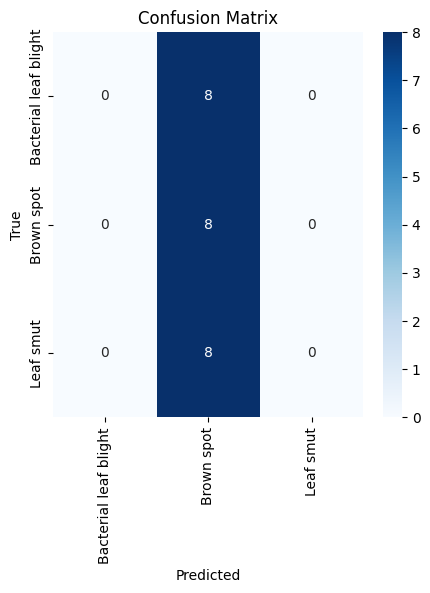

In [126]:
# Step 1: Make predictions using the trained model on the test data
y_pred = vit_model.predict_generator(test_generator)

# Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Extract true labels from the test data generator
y_true = test_generator.classes

# Step 2: Calculate accuracy, recall, and precision
accuracy_VIT = accuracy_score(y_true, y_pred_classes)
recall = recall_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')

print("Accuracy:", accuracy_VIT)
print("Recall:", recall)
print("Precision:", precision)

# Step 3: Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Get class labels from the test generator
class_labels = list(test_generator.class_indices.keys())

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

COMPARISON

In [127]:
print(f"CNN model accuracy: {accuracy_CNN}")
print(f"AlexNet model accuracy: {accuracy_alexnet}")
print(f"ResNet model accuracy: {accuracy_resnet}")
print(f"GoogleNet model accuracy: {accuracy_googlenet}")
print(f"VIT model accuracy: {accuracy_VIT}")

CNN model accuracy: 0.4583333333333333
AlexNet model accuracy: 0.25
ResNet model accuracy: 0.375
GoogleNet model accuracy: 0.4166666666666667
VIT model accuracy: 0.3333333333333333


The accuracies can improve with the increase in the size of the dataset.